In [35]:
import clean_data
from lifelines import KaplanMeierFitter, NelsonAalenFitter

In [2]:
df = clean_data.create_df_from_mongo()

import data from mongoDB to pandas dataframe


In [66]:
sample_df = df.loc[:100, :]

In [56]:
max_value = 1526169600 - 1514764800

The purpose of this notebook is to use the Lifelines module to do some user segmentation on the chess.com dataset

Things I need to do:
1. Get the first and last games played by each player (determine duration of users time on site)
2. what period of time of inactivity will I consider death (2 weeks without a game?)
3. make some graphs
4. segment population


loop through all games by an individual
    if the diff in time between the next game or current time is greater than two weeks:
        take the last time as the 'death' event
'birth' event = sign up date (maybe first game?)
duration of user 'life' = death time - birth time

In [3]:
def game_end_time(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    return df['games'][player][month][0]['games'][game]['end_time']

def user_lifetimes(df):
    end_time = 1526169600
    player_idxes = range(df.shape[0])
    all_times = []
    for player in player_idxes:
        time_of_games = []
        for month in range(5):
            try:
                for game in range(clean_data.games_in_a_month(df, player, month)):
                    time_of_games.append(game_end_time(df, player, month, game))
            except (KeyError, IndexError):
                continue
        if time_of_games:
            birth = time_of_games[0]
            death = duration(time_of_games)
            if not death:
                still_alive = time_of_games[-1] - birth
                all_times.append((still_alive, player, False))
            else:
                all_times.append(((death - birth), player, True))
        else:
            all_times.append((0, player, True))
    return all_times

def duration(time_of_games):
    seconds_in_two_weeks = 604800
    for i, x in enumerate(time_of_games):
        if x - time_of_games[i - 1] > seconds_in_two_weeks:
            return time_of_games[i - 1]

In [4]:
user_times = user_lifetimes(df)

In [36]:
def fake_death_time(time_of_games):
    seconds_in_two_weeks = 50
    times = duration(time_of_games)
    if times:
        return times[0]
    else:
        return time_of_games[-1] - time_of_games[0]
        
nums = [[2, 5, 10, 16, 24], [0, 2, 7, 8, 15, 100], [23, 25, 100, 102, 103], [], [1, 10000, 200000], [1516154262, 1516318955, 1516320601, 1516320864, 1516321154, 1516321416, 1516322103, 1516322534, 1516322614, 1516323629, 1522709922, 1522722105, 1522794278, 1522886378, 1523065535, 1523066047, 1523143799, 1523144383, 1523207447, 1523727492, 1523728070, 1523821548, 1523821610, 1523821718, 1523822394, 1524323057, 1524323888, 1524324698, 1524341290, 1524342351, 1524343346, 1524959707, 1524960033, 1525819501, 1525820389]]
for num in nums:
    if num:
#         print(death_time(num))
        print(duration(num))
    else:
        print(0)

None
15
25
0
1
1516154262


In [95]:
def duration(time_of_games):
    seconds_in_two_weeks = 604800
    for i, x in enumerate(time_of_games):
        if x - time_of_games[i - 1] > seconds_in_two_weeks:
            return time_of_games[i - 1]

In [35]:
all_times[player]

not_empty


In [25]:
for duration_, player, death_observed in user_lifetimes(df):
    df.loc[player, 'duration_days'] = duration_ / 86400 
    df.loc[player, 'death_observed'] = death_observed

In [26]:
df[['player_id', 'duration_days', 'death_observed']]

,player_id,duration_days,death_observed
0,42361082,1.960266,True
1,42121838,123.472072,False
2,42324950,0.000000,True
3,42192576,4.292639,True
4,42332948,2.931146,True
5,42762076,106.640938,False
6,42165872,124.921123,False
7,42530248,64.847269,False
8,42824544,6.849942,True
9,42425796,14.127720,True


In [17]:
df[df['duration_days'] != 0]['duration_days']

0         47.046389
1       2963.329722
3        103.023333
4         70.347500
5       2559.382500
6       2998.106944
7       1556.334444
8        164.398611
9        339.065278
10         3.206111
11      1221.253333
12        49.843333
13      1559.799444
14        12.166111
15      1433.388611
16       796.151389
17      2498.196667
18       788.331389
19      1737.035833
20       147.781111
21      2275.273889
22      2735.240278
23      1357.465000
24      1195.530000
25       123.694444
26      2809.752500
27      3083.744444
28       846.228611
31       199.189722
32         0.611667
           ...     
1419     965.934444
1420     941.739167
1421    2976.210556
1422     903.668611
1423     103.667500
1424      51.967222
1426      24.836389
1427    1174.559444
1428    2634.486667
1429    1469.288611
1430    1421.238611
1431    2453.490000
1432     312.259722
1434      70.500000
1435    2517.942778
1436    1864.823056
1437    2632.822500
1439     399.513889
1441    1501.165833


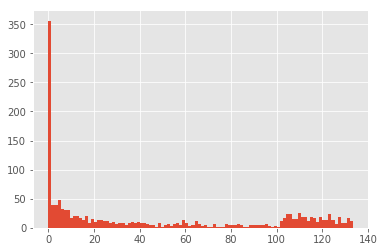

In [27]:
df['duration_days'].hist(bins=100)

In [28]:
kmf = KaplanMeierFitter()

T = df[df['duration_days'] != 0]['duration_days']
E = df[df['duration_days'] != 0]['death_observed']

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 1210 observations, 427 censored>

Text(0.5,1,'Survival Function of Chess.com Users')

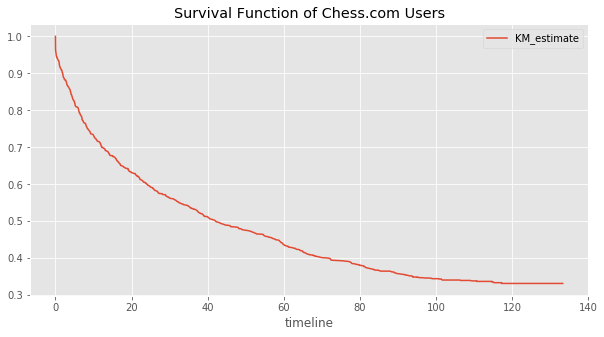

In [31]:
kmf.survival_function_.plot(figsize=(10, 5))
plt.title('Survival Function of Chess.com Users')

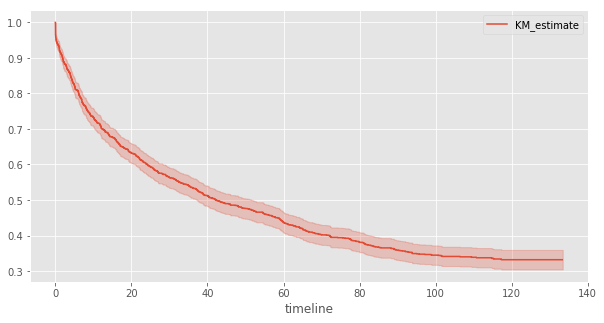

In [32]:
kmf.plot(figsize=(10, 5));

In [36]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter: fitted with 1210 observations, 427 censored>

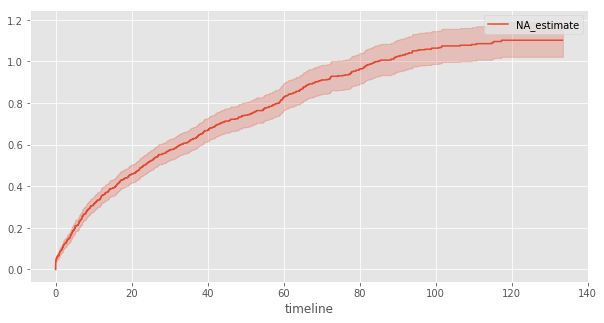

In [39]:
naf.plot(figsize=(10, 5))